# DAO

## D.1 소개

* DAO Data Access Objects는 엔터프라이즈 패턴이다.
* J2EE 패턴으로 소개되었고, DB를 사용하는 어플리케이션에 널리 적용되고 있다 (참고: Sun Microsystems Inc., 2007, Core J2EE Patterns)
* 엔터프라이즈 패턴으로 업무와 DBMS를 분리하기 위해 사용한다.
* 즉, 논리적인 데이터와 그 데이터를 어떻게 사용할 것인지 물리적인 측면을 분리한다.
* 예를 들어, 거래하는 고객과 그 정보를 어떻게 저장할지를 분리한다 (즉, 고객ID는 몇 자리로 할 것인지, 숫자 또는 문자인지 등 물리적인 문제)
* 업무 데이터와 DBMS 2계층을 분리하고, 서로 그 상태를 동일하게 유지persistence하게 된다.
    * business layer
    * data access layer

* 디자인패턴 요소

요소 | 설명
---|---
name | Dao
problem | DB를 사용하는 방법이 변경되면 클라이언트의 수정이 많아진다.
solution | 사용방법의 분리
consequence | loose coupling, 확장성

* 프로그래밍 예제
    * 과제
        * 주소록을 DB CRUD
        * 주소록을 파일 CRUD

## D.2 문제

* 데이터를 저장하는 방식이 다양하다 (데이터베이스, 파일, XML, csv 등)
* 사용하는 방법이 다르게 되면 변경이 많아지게 된다. DMBS에 따라 Sql이 서로 다를 수 있다.
* 데이터를 저장하는 방식을 분리하여, 변경을 최소화한다.

## D.3 설계

역할 | 설명
-----|-----
Dao | 모델에 대한 기본적인 CRUD 인터페이스
DaoImpl | Dao 인터페이스 구현 (실제 연결한 DBMS, sql)
Value Object (또는 Model Object) | Dao를 사용하여 데이터를 저장하는 단순 POJO

In [1]:
import iplantuml

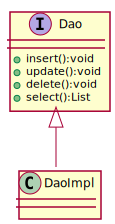

In [2]:
%%plantuml

@startuml

interface Dao {
    +insert():void    
    +update():void
    +delete():void
    +select():List
}
class DaoImpl
Dao <|.. DaoImpl
@enduml

## D.4 사례

### D.4.1 주소록 사용사례

* CRUD기능을 구현한다.
* Use Case: 주소록 관리
    * Basic Flow:
        * 1) 사용자가 주소록 (이름, 주소) 조회를 요청.
            * 단건조회
            * 목록조회
        * 2) 사용자가 입력을 요청.
        * 3) 사용자가 수정을 요청.
            * 데이터가 존재하는지 확인
        * 4) 사용자가 삭제를 요청.
            * 데이터가 존재하는지 확인
    * Alternative Flow:
        * 1-1a) DB연결 오류: "DB 연결 오류" 출력. 
        * 1-1b) 데이터가 존재하지 않는 경우: "데이터가 존재하지 않습니다" 출력. 
        * 2-1) 특수문자가 있는 경우: "특수문자 입력 오류" 출력. 
        * 3-1) 데이터 존재하지 않는 경우: "입력 오류" 출력. 

* 버전

구분 | 설명
-----|-----
v0 | simple JDBC 사례 - MySql, DAO 구현하지 않는다.
v1 | List, DAO
v2 | MySql, DAO, 수정, 삭제, 단건조회, 목록조회 (master-detail)


* Properties
    * 비밀번호는 properties에 저장하여 사용한다.
```
USER=
PASSWORD=
```

In [7]:
!ls -l src/mysql.properties

-rw-rw-r-- 1 jsl jsl 55  5월 17 10:00 src/mysql.properties


* jdbc connector를 설치한다.
    * mysql connector 다운로드 http://dev.mysql.com/downloads/connector/j
    * 압축을 풀면 mysql-connector-XXX.jar
    * classpath에 추가한다.

In [5]:
!ls -l /usr/share/java/mysql*

-rw-r--r-- 1 root root 987191  2월  7  2016 /usr/share/java/mysql-connector-java-5.1.38.jar
lrwxrwxrwx 1 root root     31  2월  7  2016 /usr/share/java/mysql-connector-java.jar -> mysql-connector-java-5.1.38.jar
lrwxrwxrwx 1 root root     24  2월  7  2016 /usr/share/java/mysql.jar -> mysql-connector-java.jar


### v0  simple JDBC

* DAO 패턴을 사용하지 않고, 데이터를 입력, 수정, 삭제, 조회
* 실행하면서 useSSL 'WARN' 메시지가 발생하면
    * "?useSSL=false"를 추가한다.

In [1]:
%%writefile src/com/sd/dao/v0/DaoMainV0.java

package com.sd.dao.v0;
import java.sql.*;
import java.util.Properties;
import java.io.FileInputStream;
import java.io.FileNotFoundException;
import java.io.IOException;

public class DaoMainV0 {
    public static void main (String[] args){
        String path = System.getProperty("user.dir");
        path += "/src/mysql.properties";
        Properties prop = new Properties();
        try {
            FileInputStream fin = new FileInputStream(path);
            prop.load(fin);
            Class.forName("com.mysql.jdbc.Driver");
            Connection conn = DriverManager.getConnection(
                prop.getProperty("URL")+"?useSSL=true",
                prop.getProperty("USER"),
                prop.getProperty("PASSWORD")
            );
            String mySql="CREATE TABLE persons(id int(64) NOT NULL AUTO_INCREMENT,";
            mySql+="name varchar(255) NOT NULL, address varchar(255) NOT NULL, UNIQUE (id))";
            conn.createStatement().execute(mySql);
            //conn.createStatement().execute("INSERT INTO persons(name,address) VALUES('js1','1 Hongji Dong')");
            //conn.createStatement().execute("INSERT INTO persons(name,address) VALUES('js2','2 Hongji Dong')");
            //conn.createStatement().execute("INSERT INTO persons(name,address) VALUES('js3','3 Hongji Dong')");

            //conn.createStatement().execute("DELETE FROM persons WHERE id=3 LIMIT 1");

            //ResultSet rs = conn.createStatement().executeQuery("SELECT name FROM persons WHERE id < 4 ORDER BY id");
            //while (rs.next() == true){
            //    System.out.println(rs.getString("name"));
            //}
            //rs.close();
            conn.close();
        }
        catch (Exception e){
            e.printStackTrace();
        }
    }
}


Overwriting src/com/sd/dao/v0/DaoMainV0.java


In [ ]:
!javac -d classes/ -sourcepath src/ src/com/sd/dao/v0/DaoMainV0.java
!java -cp classes/:/usr/share/java/mysql.jar com.sd.dao.v0.DaoMainV0

* 실행하고 mysql cli로 확인한다.

```
mysql> use test;
Database changed
mysql> show tables;
+----------------+
| Tables_in_test |
+----------------+
| persons        |
+----------------+

mysql> 
```

#### v1 LIST DAO (no JDBC)

* List로 구현해서 DAO를 사용한다. JDBC를 사용하지 않는다.
    * List는 추상클래스, ArrayList를 생성한다.
    * List에서 데이터를 가져오려면 인덱스. a.get(0)
    * 삭제는 remove(0)

In [1]:
List a = new List()

 List a = new List()
|  Error:
|  java.util.List is abstract; cannot be instantiated
|  List a = new List();
|           ^--------^



In [3]:
List a = new ArrayList()
a.add("a")
a.get(0)


 List a = new ArrayList()
|  Modified variable a of type List with initial value []
|    Update overwrote variable a

 a.add("a")
|  Warning:
|  unchecked call to add(E) as a member of the raw type java.util.List
|  a.add("a")
|  ^--------^
|  Expression value is: true
|    assigned to temporary variable $4 of type boolean

 a.get(0)
|  Expression value is: "a"
|    assigned to temporary variable $5 of type Object



In [ ]:
# %load src/com/sd/dao/v1/Student.java
package com.sd.dao.v1;
public class Student {
   private String name;
   private int rollNo;

   Student(String name, int rollNo){
      this.name = name;
      this.rollNo = rollNo;
   }
   public String getName() {
      return name;
   }
   public void setName(String name) {
      this.name = name;
   }
   public int getRollNo() {
      return rollNo;
   }
   public void setRollNo(int rollNo) {
      this.rollNo = rollNo;
   }
}


In [ ]:
# %load src/com/sd/dao/v1/StudentDao.java
package com.sd.dao.v1;
import java.util.List;

public interface StudentDao {
   public List<Student> getAllStudents();
   public Student getStudent(int rollNo);
   public void updateStudent(Student student);
   public void deleteStudent(Student student);
}


In [2]:
%%writefile src/com/sd/dao/v1/StudentDaoImpl.java
package com.sd.dao.v1;
import java.util.ArrayList;
import java.util.List;

public class StudentDaoImpl implements StudentDao {
   List<Student> students;
   public StudentDaoImpl(){
      students = new ArrayList<Student>();
      Student s1 = new Student("js1",0);
      Student s2 = new Student("js2",1);
      students.add(s1);
      students.add(s2);           
   }
   @Override
   public void deleteStudent(Student student) {
      students.remove(student.getRollNo());
      System.out.println("Student: No "+student.getRollNo()+" deleted");
   }

   @Override
   public List<Student> getAllStudents() {
      return students;
   }

   @Override
   public Student getStudent(int rollNo) {
      return students.get(rollNo);
   }

   @Override
   public void updateStudent(Student student) {
      students.get(student.getRollNo()).setName(student.getName());
      System.out.println("Student: No "+student.getRollNo()+" updated");
   }
}


Overwriting src/com/sd/dao/v1/StudentDaoImpl.java


In [3]:
%%writefile src/com/sd/dao/v1/DaoMainV1.java
package com.sd.dao.v1;

public class DaoMainV1 {
   public static void main(String[] args) {
      StudentDao studentDao = new StudentDaoImpl();

      //print all students
      for (Student student : studentDao.getAllStudents()) {
         System.out.println("Student: No "+student.getRollNo()
            +", "+student.getName());
      }

      //update student
      Student student =studentDao.getAllStudents().get(0);
      student.setName("js new");
      studentDao.updateStudent(student);

      //get the student
      studentDao.getStudent(0);
      System.out.println("Student: No "+student.getRollNo()
         +", "+student.getName());
   }
}


Overwriting src/com/sd/dao/v1/DaoMainV1.java


In [ ]:
!javac -d classes/ -sourcepath src/ src/com/sd/dao/v1/DaoMainV1.java
!java com.sd.dao.v1.DaoMainV1

#### v2 MySql DAO

* v0에서 'persons' 테이블이 생성되어 있어야 한다.
* PreparedStatment

* boolean execute() - any kind of SQL statement.
* ResultSet executeQuery() the ResultSet object generated by the query.
* int executeUpdate() SQL INSERT, UPDATE or DELETE statement; or an SQL statement that returns nothing, such as a DDL statement.

* public void insert(Customer customer) throws CustomerDAOException;
* public void update(CustomerPK pk, Customer customer) throws CustomerDAOException;
* public void delete(CustomerPK pk) throws CustomerDAOException;
* public Customer[] findAll() throws CustomerDAOException;
* public Customer findByPrimaryKey(String email) throws CustomerDAOException;
* public Customer[] findByCompany(int companyId) throws CustomerDAOException;

In [19]:
%%writefile src/com/sd/dao/v2/PersonVO.java
package com.sd.dao.v2;

public class PersonVO {
    private int id;
    private String name;
    private String address;
    public int getId() {
        return id;
    }
    public void setId(int id) {
        this.id = id;
    }
    public String getName() {
        return name;
    }
    public void setName(String name) {
        this.name = name;
    }
    public String getAddress() {
        return address;
    }
    public void setAddress(String address) {
        this.address = address;
    }
    public String toString(){
        return "ID: "+id+" Name: "+name+" Address: "+address;
    }
}


Overwriting src/com/sd/dao/v2/PersonVO.java


In [ ]:
# %load src/com/sd/dao/v2/PersonDAO.java
package com.sd.dao.v2;

import java.util.List;

public interface PersonDAO {
    public void insert(PersonVO person);
    public List<PersonVO> select();
}


In [18]:
%%writefile src/com/sd/dao/v2/PersonDAOImpl.java
package com.sd.dao.v2;

import java.sql.Connection;
import java.sql.DriverManager;
import java.sql.PreparedStatement;
import java.sql.ResultSet;
import java.sql.SQLException;
import java.sql.Statement;
import java.util.LinkedList;
import java.util.List;
import java.util.Properties;
import java.io.FileInputStream;
import java.io.FileNotFoundException;
import java.io.IOException;

public class PersonDAOImpl implements PersonDAO {
    Connection conn = null;
    public Connection getConnection(){
        String path = System.getProperty("user.dir");
        path += "/src/mysql.properties";
        Properties prop = new Properties();
        try {
            FileInputStream fin = new FileInputStream(path);
            prop.load(fin);
            Class.forName("com.mysql.jdbc.Driver");
            if(conn == null)
                conn = DriverManager.getConnection(
                    prop.getProperty("URL")+"?useSSL=true",
                    prop.getProperty("USER"),
                    prop.getProperty("PASSWORD")
                );
        } catch (IOException e) {
            e.printStackTrace();
        } catch (ClassNotFoundException e) {
            e.printStackTrace();
        } catch (SQLException e) {
            e.printStackTrace();
        }
        return conn;
    }
    @Override
    public void insert(PersonVO person) {
        try {
            PreparedStatement preparedStatement = conn.prepareStatement("INSERT INTO persons(id,name,address) VALUES(NULL,?,?)");
            preparedStatement.setString(1, person.getName());
            preparedStatement.setString(2, person.getAddress());
            System.out.println("inserting..."+person.getName()+person.getAddress());
            preparedStatement.executeUpdate();
            preparedStatement.close();
        } catch (SQLException e) {
            // TODO Auto-generated catch block
            e.printStackTrace();
        }
    }
    @Override
    public List<PersonVO> select() {
        List<PersonVO> persons = new LinkedList<PersonVO>();
        try {
            Statement statement = conn.createStatement();
            ResultSet resultSet = statement.executeQuery("SELECT * FROM persons");
            PersonVO person = null;
            while(resultSet.next()){
                person = new PersonVO();
                person.setId(Integer.parseInt(resultSet.getString("id")));
                person.setName(resultSet.getString("name"));
                person.setAddress(resultSet.getString("address"));
                persons.add(person);
            }
            resultSet.close();
            statement.close();
        } catch (SQLException e) {
            e.printStackTrace();
        }
        System.out.println(persons);
        return persons;
    }
    public void closeConnection(){
        try {
            if (conn != null) {
                conn.close();
            }
        } catch (Exception e) { 
            //do nothing
        }
    }
}


Overwriting src/com/sd/dao/v2/PersonDAOImpl.java


In [15]:
%%writefile src/com/sd/dao/v2/DaoMainV2.java
package com.sd.dao.v2;

public class DaoMainV2 {
    public static void main(String args[]){
        PersonVO person = new PersonVO();
        person.setName("js1");
        person.setAddress("1 Hongji-dong");

        PersonDAOImpl personDAOImpl = new PersonDAOImpl();
        personDAOImpl.getConnection();
        personDAOImpl.insert(person);

        person.setName("js2");
        person.setAddress("2 Hongji-dong");
        personDAOImpl.insert(person);

        personDAOImpl.select();
        personDAOImpl.closeConnection();
    }
}


Overwriting src/com/sd/dao/v2/DaoMainV2.java


In [ ]:
!javac -d classes/ -sourcepath src/ src/com/sd/dao/v2/*.java
java -cp classes/:/usr/share/java/mysql.jar com.sd.dao.v2.DaoMainV2 

* mysql cli로 확인
```
mysql> select * from persons;
+----+--------------+---------------+
| id | name         | address       |
+----+--------------+---------------+
|  1 | js1          | 1 Hongji-dong |
|  1 | js2          | 2 Hongji-dong |
+----+--------------+---------------+
```

## AddressBook

* see jython book (AddressBook case)

### AddressBook v1

* http://codereview.stackexchange.com/questions/30019/simple-address-book-in-java
    - file persistence(serialize)
    - LIST dao 
* javac -d classes/ -sourcepath src/ src/com/sd/addressBook/v1/*.java
* java com.sd.addressBook.v1.AddressBookMainV1
* vim AddressBooks.txt 

### AddressBook v2

*http://www.codemiles.com/finished-projects/address-book-in-java-t1182.html

* AddressBook
* Contact - serializable
* OperationHandler -- thread (input/data.dat)

* javac -d classes/ -sourcepath src/ src/com/sd/addressBook/v2/*.java
* java com.sd.addressBook.v2.AddressBook

### AddressBook v3 jdbc

* google search swing dao mysql addressbook
* http://www.javabeginner.com/java-swing/java-swing-address-book
* http://alvinalexander.com/ooa-ood/java-model-view-controller-mvc-example-1